# (K) Nearest Neighbours - Meuse Dataset

https://scikit-activeml.github.io/scikit-activeml-docs/generated/api/skactiveml.visualization.plot_decision_boundary.html
https://github.com/scikit-activeml/scikit-activeml
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
http://localhost:8888/notebooks/OneDrive/AY2022%20Y3S2%20Exchange/Machine%20Learning%201/Practicals/Practical%206/P6.ipynb

## Importing packages and loading necessary datasets

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotting
import skactiveml.visualization as skactive
from skactiveml.visualization import plot_decision_boundary
from sklearn.cluster import KMeans
import geopandas as gpd

In [2]:
meuse_df = pd.read_csv("meuse_processed.csv")

K-Means clustering is done here to assign each data point to a specific cluster, this will be used when conducting spatial cross validation. GridSearchCV is also done for the hyperparameter tuning of the number of clusters.

In [3]:
meuse_df

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,cluster_num
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50,0
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30,0
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150,0
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270,0
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540,7
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520,7
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350,1
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460,7


## Splitting Data

First, we will be splitting the data into training and test datsaset. Whereby the training data is used to train the model and conduct cross validation, while the test data is used to evaluate the performance of the trained model obtained from the training data. 

In [4]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y', 'cluster_num']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

X_train_meuse and y_train_meuse are the training data whereby X_train_meuse contains the spatial information i.e Data Coordinates and the cluster number assigned using the K-Means algorithm previously. The y_train_meuse will be sampled values of each data coordinates in X_train_meuse. The same is done for the test data. 

In [5]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 3)
X_test_meuse.shape:  (31, 3)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## Understanding distribution of clusters in train and test sets 

In [6]:
x_values = [element[0] for element in X_train_meuse]
y_values = [element[1] for element in X_train_meuse]
cluster_values = [element[2] for element in X_train_meuse]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_meuse]
y_values_test = [element[1] for element in X_test_meuse]
cluster_values_test = [element[2] for element in X_test_meuse]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [7]:
train_df.describe(include='all')

,x,y,cluster_num
count,124.000000,124.000000,124.0
unique,NaN,NaN,8.0
top,NaN,NaN,0.0
freq,NaN,NaN,19.0
mean,180033.290323,331681.548387,NaN
std,744.898103,1048.719020,NaN
min,178605.000000,329714.000000,NaN
25%,179437.250000,330792.500000,NaN
50%,180083.500000,331697.000000,NaN
75%,180655.000000,332509.250000,NaN


<Axes: >

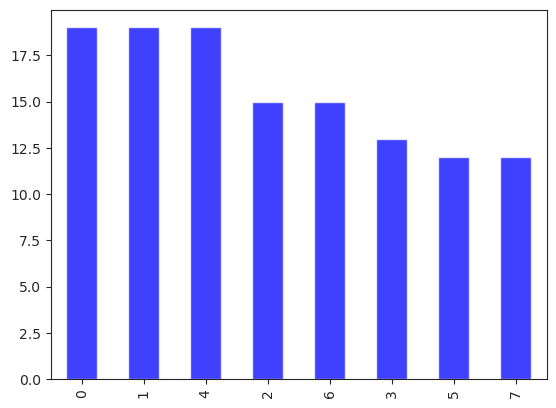

In [8]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

In [9]:
test_df.describe(include='all')

,x,y,cluster_num
count,31.000000,31.000000,31.0
unique,NaN,NaN,8.0
top,NaN,NaN,1.0
freq,NaN,NaN,9.0
mean,179889.838710,331448.483871,NaN
std,751.728191,1039.762148,NaN
min,178803.000000,329733.000000,NaN
25%,179150.000000,330572.500000,NaN
50%,179792.000000,331150.000000,NaN
75%,180486.000000,332314.500000,NaN


<Axes: >

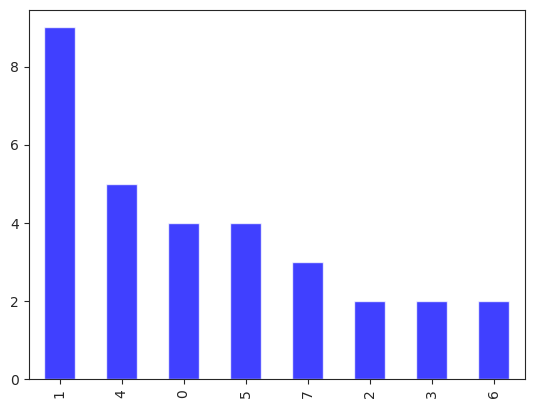

In [10]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

# Spatial  K - Fold Cross Validation

In [11]:
x_values = [element[0] for element in X_train_meuse]
y_values = [element[1] for element in X_train_meuse]
cluster_values = [element[2] for element in X_train_meuse]

In [12]:
group_kfold = GroupKFold(n_splits = 8) 
# Generator for the train/test indices
cluster_kfold = group_kfold.split(x_values,y_values,cluster_values)  
train_indices, test_indices = [list(traintest) for traintest in zip(*cluster_kfold)]
spatial_cv = [*zip(train_indices,test_indices)]

## K-Fold Cross Validation

Now we will train and cross validate the model using the training data. GridSearchCV is used whereby we pass in the model we will be using (K Nearest Nieghbours AKA KNeighborsRegressor()), along with the list of hyperparameters we would like to tune, it would then conduct K-Fold Cross validation and return the model with best hyperparamter configuration. It can also return the mean cross validation score of the best model it has found. In our approach, we will use 1 scoring metric/method for the namely Mean Absolute Percentage Error to determine how the best hyperparamter configuration can be determined. i.e GridSearchCV will score each K-Fold of cross validation for each hyperparameter configuration using this metric, and return us the model with the best hyperparameter configuration or with the lowest Mean Absolute Percentage Error it has seen.

However, I have also included other scoring metrics such as RMSE and MAE, as GridSearchCV is able to conduct multi-metric evaluation as well. By doing so, we can obtain the scores obtained for each of these metrics as well and conduct further analysis. The computational time is also calculated as it can be useful for comparison across the different spatial interpolation methods later on.

https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo (Reason why K-Fold preferred)

In [13]:
# Define the range of n_neighbors for hyperparameter tuning
neighbors_range = np.arange(1, 20)
nn_model = KNeighborsRegressor()
parameters = [
    {'n_neighbors': neighbors_range}
]

scoring_methods = ['neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
clf = GridSearchCV(cv= spatial_cv, estimator = nn_model, param_grid = parameters, return_train_score=True, scoring= scoring_methods, refit = 'neg_mean_absolute_percentage_error')

start_time = time.time()

clf.fit(X_train_meuse, y_train_meuse)

end_time = time.time()

print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

Training Computation Time: 0.39 seconds


## Hyperparameter selection

Here, we can understand how GridSearch CV came to the conclusion of which hyperparameter configuration would provide the best model by analysing the cv_results_, which is a dataframe of the training and cross validated scores it has obtained in the process.

In [14]:
cv_results_df = pd.DataFrame(clf.cv_results_)
display(cv_results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,...,split0_train_r2,split1_train_r2,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,mean_train_r2,std_train_r2
0,0.000251,0.000434,0.001168,0.000343,1,{'n_neighbors': 1},-0.051347,-0.063960,-0.055767,-0.103984,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.000250,0.000434,0.001001,0.000007,2,{'n_neighbors': 2},-0.044562,-0.076428,-0.057527,-0.063254,...,0.828976,0.829283,0.830896,0.868849,0.831365,0.848499,0.841405,0.836840,0.839514,0.012789
2,0.000125,0.000332,0.001451,0.000470,3,{'n_neighbors': 3},-0.047090,-0.076721,-0.052345,-0.064156,...,0.748110,0.752518,0.747971,0.776475,0.732224,0.751629,0.778216,0.802754,0.761237,0.021221
3,0.000318,0.000437,0.000817,0.000610,4,{'n_neighbors': 4},-0.053618,-0.076133,-0.060269,-0.074336,...,0.726905,0.730577,0.737118,0.752276,0.712100,0.739640,0.756436,0.784186,0.742405,0.020537
4,0.000322,0.000438,0.001004,0.000024,5,{'n_neighbors': 5},-0.056096,-0.075067,-0.059986,-0.060115,...,0.646969,0.641615,0.639945,0.686646,0.624410,0.670930,0.663315,0.687534,0.657670,0.021598
5,0.000327,0.000446,0.000625,0.000484,6,{'n_neighbors': 6},-0.054655,-0.082667,-0.067058,-0.066846,...,0.646680,0.645714,0.648756,0.662574,0.619377,0.656566,0.671686,0.679964,0.653915,0.017376
6,0.000271,0.000370,0.000995,0.000030,7,{'n_neighbors': 7},-0.059922,-0.091659,-0.074014,-0.073669,...,0.589464,0.588167,0.607829,0.622982,0.582866,0.595108,0.620847,0.627718,0.604373,0.016613
7,0.000317,0.000431,0.000765,0.000351,8,{'n_neighbors': 8},-0.062763,-0.091006,-0.072835,-0.073970,...,0.557493,0.556397,0.564911,0.590863,0.545386,0.566434,0.590564,0.595415,0.570933,0.017618
8,0.000692,0.000563,0.000637,0.000417,9,{'n_neighbors': 9},-0.067115,-0.089257,-0.074693,-0.070817,...,0.564142,0.562772,0.573008,0.590452,0.562280,0.557909,0.596834,0.615303,0.577837,0.019367
9,0.000438,0.000464,0.000878,0.000213,10,{'n_neighbors': 10},-0.071923,-0.094539,-0.074594,-0.075387,...,0.528994,0.533101,0.534358,0.567361,0.525242,0.532346,0.564270,0.582368,0.546005,0.020375


We can see that the optimal number of neighbours chosen is 3 by GridSearchCV.

In [15]:
print(f"Dataset: {clf.best_params_}")
print(f"Mean Cross-Validated Score of Best Estimator (Mean Absolute Percentage Error): {-clf.best_score_}")
columns = ['param_n_neighbors','mean_test_neg_mean_absolute_percentage_error','rank_test_neg_mean_absolute_percentage_error',
           'mean_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error',
            'mean_test_neg_root_mean_squared_error', 'rank_test_neg_root_mean_squared_error', 'mean_test_r2', 'rank_test_r2']
filter_df = cv_results_df[columns]
display(filter_df)

Dataset: {'n_neighbors': 3}
Mean Cross-Validated Score of Best Estimator (Mean Absolute Percentage Error): 0.07691495617213087


,param_n_neighbors,mean_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_test_r2,rank_test_r2
0,1,-0.078752,3,-0.484721,3,-0.645600,6,0.000381,5
1,2,-0.077102,2,-0.473309,1,-0.620670,3,0.056512,2
2,3,-0.076915,1,-0.474499,2,-0.612863,1,0.082647,1
3,4,-0.081105,4,-0.495073,4,-0.620611,2,0.053791,3
4,5,-0.082997,5,-0.505307,5,-0.627006,4,0.000465,4
5,6,-0.086140,6,-0.521974,6,-0.630786,5,-0.020651,6
6,7,-0.090294,7,-0.545870,7,-0.651037,7,-0.080454,7
7,8,-0.092940,8,-0.561056,8,-0.665576,8,-0.140908,8
8,9,-0.095237,9,-0.573279,9,-0.679995,9,-0.206853,9
9,10,-0.099045,10,-0.594655,10,-0.696962,10,-0.274579,10


In [16]:
rank_columns = ['param_n_neighbors','rank_test_neg_mean_absolute_percentage_error',
                'rank_test_neg_mean_absolute_error','rank_test_neg_root_mean_squared_error', 'rank_test_r2']
rank_df = cv_results_df[rank_columns]
display(rank_df.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
param_n_neighbors,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
rank_test_neg_mean_absolute_percentage_error,3,2,1,4,5,6,7,8,9,10,11,12,13,14,15,17,16,19,18
rank_test_neg_mean_absolute_error,3,1,2,4,5,6,7,8,9,10,11,12,13,15,14,17,16,19,18
rank_test_neg_root_mean_squared_error,6,3,1,2,4,5,7,8,9,10,11,12,14,17,15,16,13,18,19
rank_test_r2,5,2,1,3,4,6,7,8,9,10,11,13,14,18,16,15,12,17,19


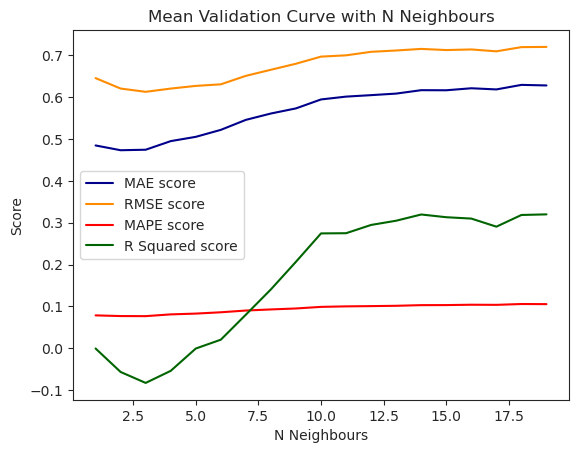

In [17]:
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_mean_absolute_error"], color='darkblue', label='MAE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_root_mean_squared_error"], color='darkorange', label='RMSE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_mean_absolute_percentage_error"], color='red', label='MAPE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_r2"], color='darkgreen', label='R Squared score')

plt.xlabel('N Neighbours')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with N Neighbours")
plt.show()

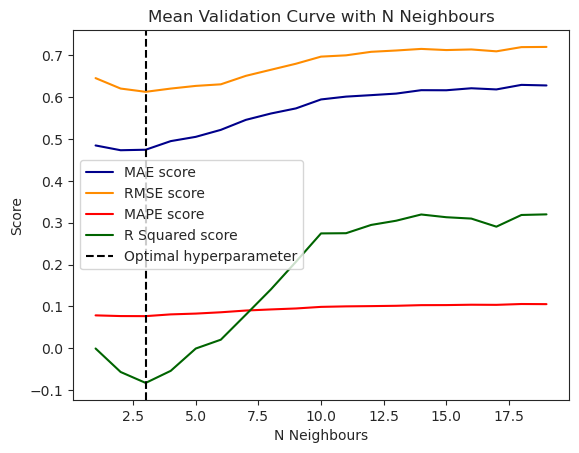

In [18]:
n_neighbours = 3
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_mean_absolute_error"], color='darkblue', label='MAE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_root_mean_squared_error"], color='darkorange', label='RMSE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_neg_mean_absolute_percentage_error"], color='red', label='MAPE score')
plt.plot(neighbors_range, -cv_results_df["mean_test_r2"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbours, c='k', ls='--', label = "Optimal hyperparameter")


plt.xlabel('N Neighbours')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with N Neighbours")
plt.show()

## Evaluation of Model (Testing Chosen model)

Now, we will use the test data namely X_test_meuse and y_test_meuse to evaluate the model's performance. We will evaluate on a few different scoring metrics for more comprehensive analysis between different spatial interpolation methods afterwards

### Performance Metrics of Model

We can include in the test score in the previous plot obtained to have an overall big picture.

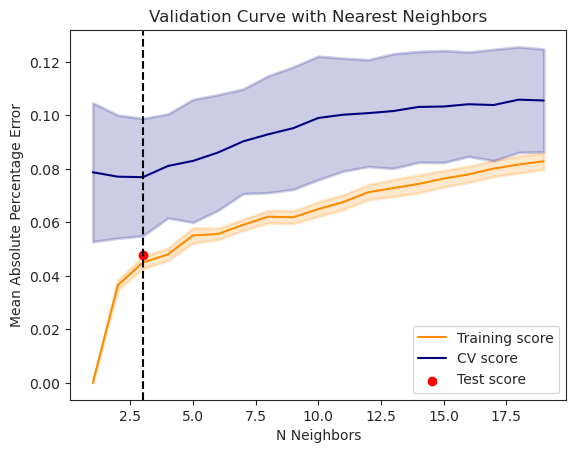

Testing Computation Time: 0.00 seconds


In [21]:
mean_train_score = -clf.cv_results_['mean_train_neg_mean_absolute_percentage_error']
mean_test_score = -clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'] #this is the validation score 
std_train_score = clf.cv_results_['std_train_neg_mean_absolute_percentage_error']
std_test_score = clf.cv_results_['std_test_neg_mean_absolute_percentage_error']

plt.plot(neighbors_range, mean_train_score, color='darkorange', label='Training score')
plt.fill_between(
    neighbors_range,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(neighbors_range, mean_test_score, color='navy', label='CV score')
plt.fill_between(
    neighbors_range,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

start_time = time.time()
test_score = -clf.score(X_test_meuse, y_test_meuse)
end_time = time.time()

best_n = clf.best_params_['n_neighbors']
plt.axvline(best_n, c='k', ls='--')
plt.scatter(best_n, test_score, c='r', label='Test score')

plt.xlabel('N Neighbors')
plt.ylabel('Mean Absolute Percentage Error')
#plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors")
plt.show()

print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

We can also see how the model performs on the test set using the 2 other metrics RMSE and MAE.

In [22]:
y_pred_meuse = clf.best_estimator_.predict(X_test_meuse)
mae = mean_absolute_error(y_test_meuse, y_pred_meuse)
rmse = np.sqrt(mean_squared_error(y_test_meuse, y_pred_meuse))
r2 = r2_score(y_test_meuse,y_pred_meuse)
print("MAPE:", test_score)
print("MAE:", mae)
print("RMSE:", rmse)
print("R Squared:", r2)

MAPE: 0.04781046934818642
MAE: 0.2710859089473497
RMSE: 0.37364890238795007
R Squared: 0.6801133527758294


### Plotting Spatial Interpolation of entire area with Model

Now, we will plot the entire spatially interpolated values of the entire surface to analyze the spatial distribution. Previously, we have found the best hyperparameter configuration which is where number of neighbors = 5, thus we will refit the model with the entire dataset with this hyperparamater configuration to plot the entire area spatially interpolated.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor (Kneighbors package used)

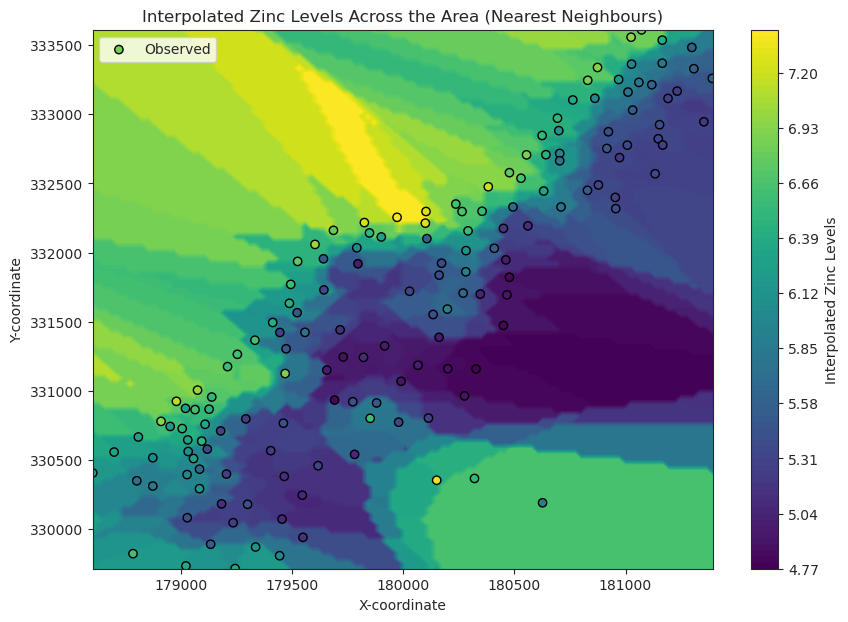

Spatial Interpolation Computation Time: 0.02 seconds


In [29]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Hyperparamter tuned: Number of nearest neighbors to consider
n_neighbors = 3

# Initialize NearestNeighbors model
nn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Perform spatial interpolation over the entire dataset for visualization
nn_model.fit(observed_locations,observed_values)  # Re-fit model using all data
x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values
interpolated_values = np.mean(observed_values[indices], axis=1)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (Nearest Neighbours)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

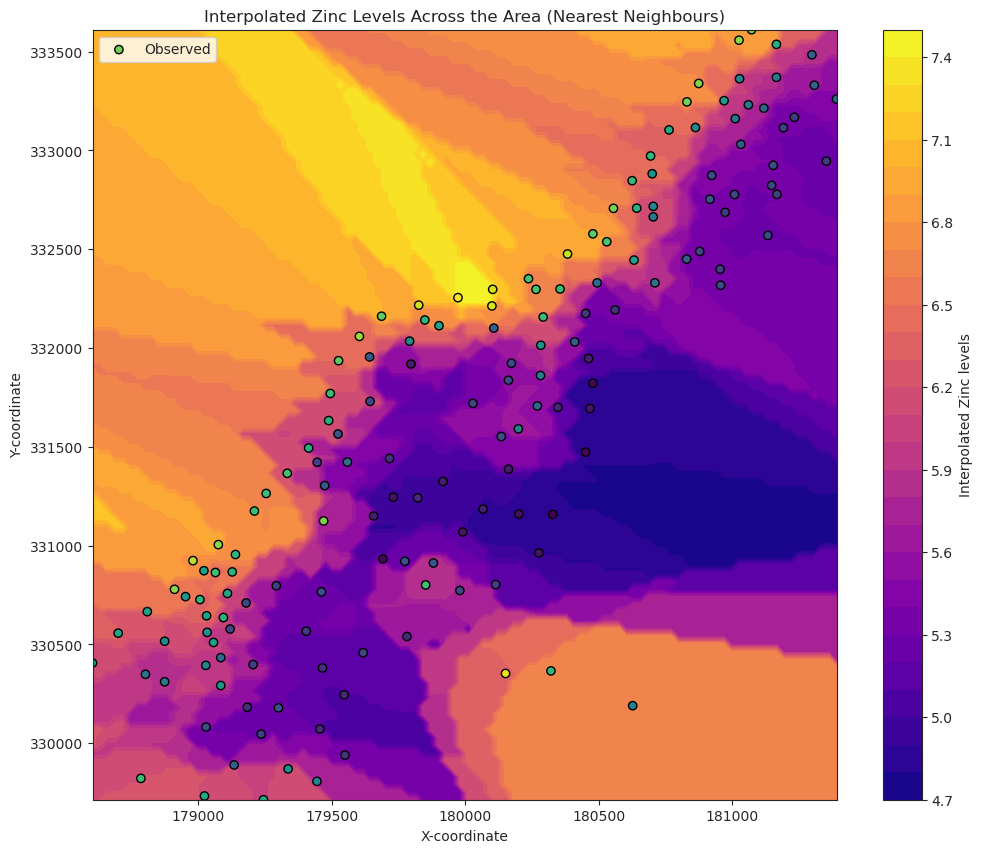

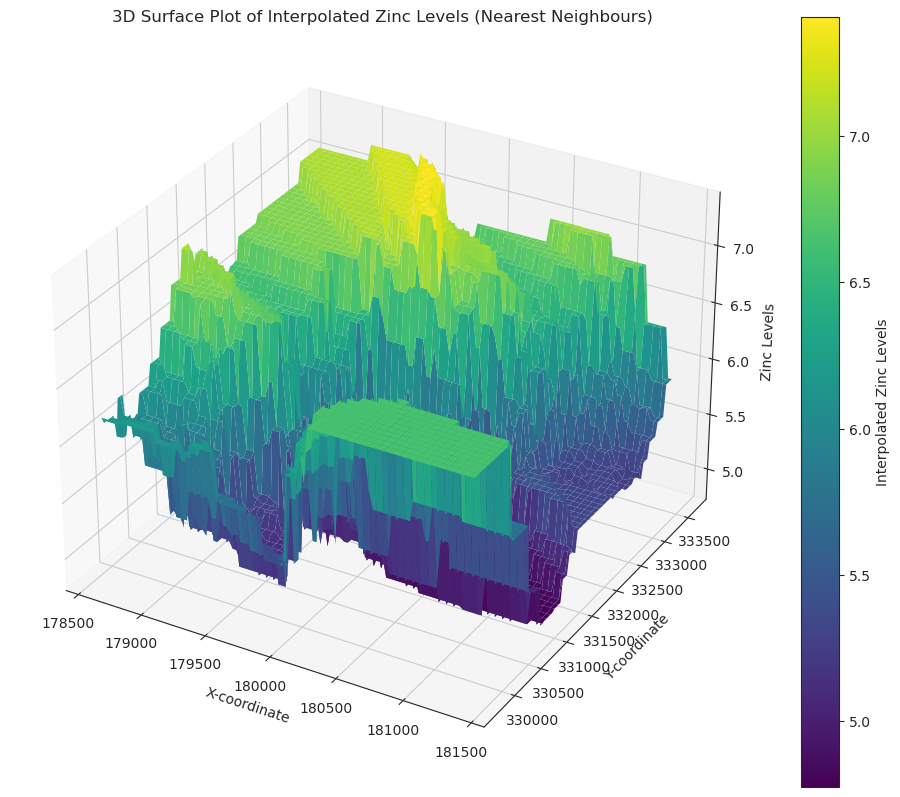

In [33]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Hyperparamter tuned: Number of nearest neighbors to consider
n_neighbors = 3

# Initialize NearestNeighbors model
nn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
nn_model.fit(observed_locations,observed_values)

# Find nearest neighbors for the grid points
distances, indices = nn_model.kneighbors(grid_points)

# Interpolate values
interpolated_values = np.mean(observed_values[indices], axis=1)
z_grid = interpolated_values.reshape(x_grid.shape)

fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated Zinc levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (Nearest Neighbours)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated Zinc Levels')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Zinc Levels')
ax.set_title('3D Surface Plot of Interpolated Zinc Levels (Nearest Neighbours)')
plt.show()

# Overfitting Analysis

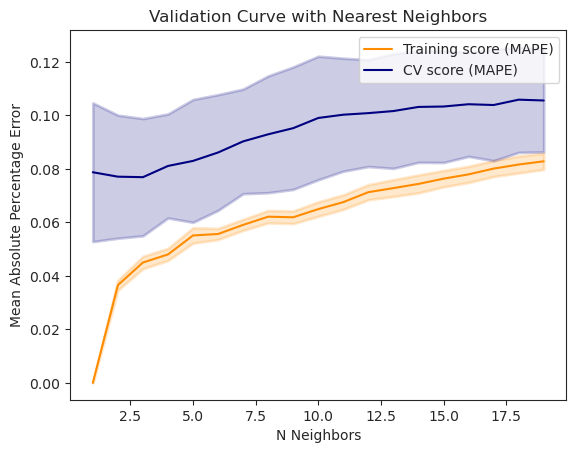

In [21]:
mean_train_score = -clf.cv_results_['mean_train_neg_mean_absolute_percentage_error']
mean_test_score = -clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'] #this is the validation score 
std_train_score = clf.cv_results_['std_train_neg_mean_absolute_percentage_error']
std_test_score = clf.cv_results_['std_test_neg_mean_absolute_percentage_error']

plt.plot(neighbors_range, mean_train_score, color='darkorange', label='Training score (MAPE)')
plt.fill_between(
    neighbors_range,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(neighbors_range, mean_test_score, color='navy', label='CV score (MAPE)')
plt.fill_between(
    neighbors_range,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

best_n = clf.best_params_['n_neighbors']
plt.axvline(best_n, c='k', ls='--')
plt.scatter(best_n, test_score, c='r', label='Test score')

plt.xlabel('N Neighbors')
plt.ylabel('Mean Absolute Percentage Error')
#plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors")
plt.show()

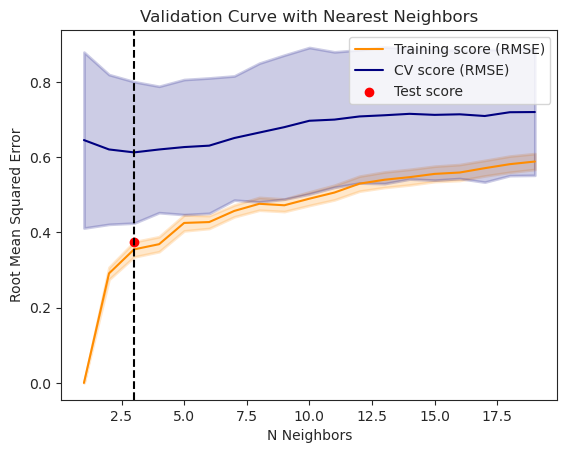

In [23]:
mean_train_score = -clf.cv_results_['mean_train_neg_root_mean_squared_error']
mean_test_score = -clf.cv_results_['mean_test_neg_root_mean_squared_error'] #this is the validation score 
std_train_score = clf.cv_results_['std_train_neg_root_mean_squared_error']
std_test_score = clf.cv_results_['std_test_neg_root_mean_squared_error']

plt.plot(neighbors_range, mean_train_score, color='darkorange', label='Training score (RMSE)')
plt.fill_between(
    neighbors_range,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(neighbors_range, mean_test_score, color='navy', label='CV score (RMSE)')
plt.fill_between(
    neighbors_range,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)


best_n = clf.best_params_['n_neighbors']
plt.axvline(best_n, c='k', ls='--')
plt.scatter(best_n, rmse, c='r', label='Test score')

plt.xlabel('N Neighbors')
plt.ylabel('Root Mean Squared Error')
#plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors")
plt.show()

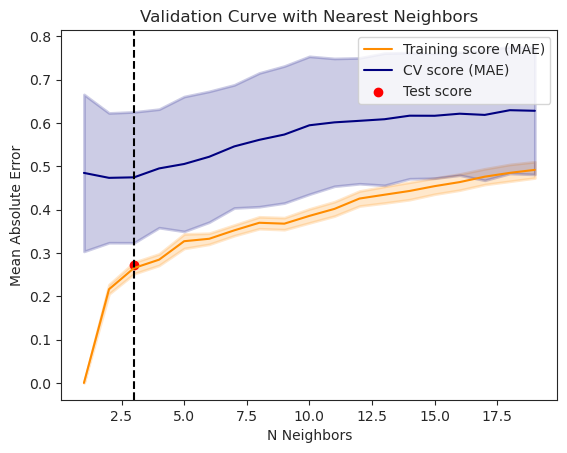

In [24]:
mean_train_score = -clf.cv_results_['mean_train_neg_mean_absolute_error']
mean_test_score = -clf.cv_results_['mean_test_neg_mean_absolute_error'] #this is the validation score 
std_train_score = clf.cv_results_['std_train_neg_mean_absolute_error']
std_test_score = clf.cv_results_['std_test_neg_mean_absolute_error']

plt.plot(neighbors_range, mean_train_score, color='darkorange', label='Training score (MAE)')
plt.fill_between(
    neighbors_range,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(neighbors_range, mean_test_score, color='navy', label='CV score (MAE)')
plt.fill_between(
    neighbors_range,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

best_n = clf.best_params_['n_neighbors']
plt.axvline(best_n, c='k', ls='--')
plt.scatter(best_n, mae, c='r', label='Test score')

plt.xlabel('N Neighbors')
plt.ylabel('Mean Absolute Error')
#plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors")
plt.show()

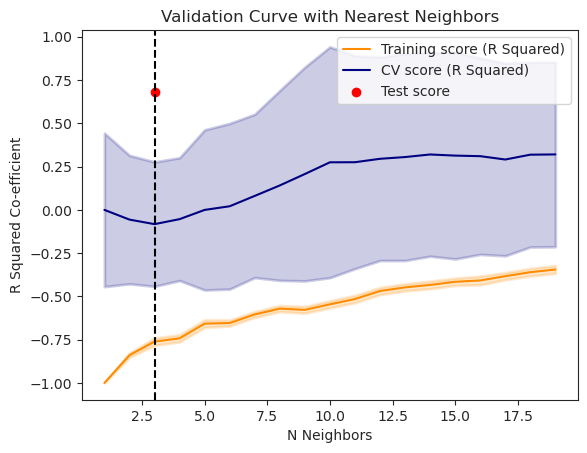

In [25]:
mean_train_score = -clf.cv_results_['mean_train_r2']
mean_test_score = -clf.cv_results_['mean_test_r2'] #this is the validation score 
std_train_score = clf.cv_results_['std_train_r2']
std_test_score = clf.cv_results_['std_test_r2']

plt.plot(neighbors_range, mean_train_score, color='darkorange', label='Training score (R Squared)')
plt.fill_between(
    neighbors_range,
    mean_train_score - std_train_score,
    mean_train_score + std_train_score,
    alpha=0.2,
    color="darkorange",
    lw=2,
)
plt.plot(neighbors_range, mean_test_score, color='navy', label='CV score (R Squared)')
plt.fill_between(
    neighbors_range,
    mean_test_score - std_test_score,
    mean_test_score + std_test_score,
    alpha=0.2,
    color="navy",
    lw=2,
)

best_n = clf.best_params_['n_neighbors']
plt.axvline(best_n, c='k', ls='--')
plt.scatter(best_n, r2, c='r', label='Test score')

plt.xlabel('N Neighbors')
plt.ylabel('R Squared Co-efficient')
#plt.yscale('log')
plt.legend()
plt.title("Validation Curve with Nearest Neighbors")
plt.show()